# 2. Aligning ACS and EPA Data

Our historical air quality data from the EPA is provided station by station, and the positions of each station is provided by coordinates. To make useful comparisons, we want to align the data - decide for each year which exact air quality data points align with each CBSA GeoID/region in ACS.

We'll refer to these as `epa_point` and `acs_region` respectively.

In [3]:
# set up path to app credentials - see exploration/README.md
%env GOOGLE_APPLICATION_CREDENTIALS=../google_app_credentials.json

# set up bigquery client
from google.cloud import bigquery
bq = bigquery.Client()

# set up some parameters
BQ_DATASET_ID = 'data'

env: GOOGLE_APPLICATION_CREDENTIALS=../google_app_credentials.json


In [4]:
# set up some dependencies
import json, time, random

import geopandas as gp
import pandas as pd
import matplotlib.pyplot as plt
import descartes # for plotting with geopanadas

First we'll load up the relevant data, which should already be set up.

In [5]:
# set up acs utils
resp = bq.query('''
    SELECT DISTINCT do_date AS year
    FROM `eosc410-project.data.acs_cbsa_20*`
    ORDER BY do_date ASC
''')
acs_years = [row["year"] for row in resp]

def load_geojson(y) -> gp.GeoDataFrame:
    print('=> loading %s' % y)
    geo = gp.read_file('../_data/tmp/acs_cbsa_%s/geojson.json' % y)
    return geo

def get_acs_year(i: int) -> str:
    return str(int(acs_years[0]) + i)

In [5]:
# look at what our geojson looks like
test_year = '2007'
test_region_geojson = load_geojson(test_year)
print('%s has %d features (regions)' % (test_year, len(test_region_geojson)))

test_region = test_region_geojson.loc[0] # first region in this year
print(test_region)
test_region_id = test_region['CBSAFP']   # current metropolitan statistical area/micropolitan statistical area code
                                         # see https://www2.census.gov/geo/pdfs/maps-data/data/tiger/tgrshp2014/TGRSHP2014_TechDoc_Ch3.pdf
test_region_name = test_region['NAME']   # this region has a name
test_region_geo = test_region.geometry   # this region has a geometry
print('%s %s: %s' % (test_year, test_region_id, test_region_name))
print(json.dumps(test_region_geo.__geo_interface__)[:100] + "...")

=> loading 2007
2007 has 952 features (regions)
CSAFP                                                        
CBSAFP                                                  27980
NAME                                      Kahului-Wailuku, HI
NAMELSAD    Kahului-Wailuku, HI Micropolitan Statistical Area
LSAD                                                       M2
MEMI                                                        2
MTFCC                                                   G3110
FUNCSTAT                                                    S
geometry    (POLYGON ((-156.705406 20.82632, -156.711227 2...
Name: 0, dtype: object
2007 27980: Kahului-Wailuku, HI
{"type": "MultiPolygon", "coordinates": [[[[-156.70540599999998, 20.82632], [-156.711227, 20.832228]...


In [6]:
# for each year and acs region, we want to get associated station numbers
# try with the test region: find all EPA points that fall within this region's geometry in that year
resp = bq.query('''
SELECT DISTINCT state_code, county_code, site_num, address, cbsa_name
FROM `eosc410-project.data.epa_air_quality_annual` as epa
WHERE
  ST_WITHIN(ST_GEOGPOINT(epa.longitude, epa.latitude), ST_GEOGFROMGEOJSON('%s'))
  AND year = %s
''' % (json.dumps(test_region_geo.__geo_interface__), test_year))
print('Stations in region %s "%s" in %s:' % (test_region_id, test_region_name, test_year))
for row in resp:
    print('site %s.%s.%s (%s, %s)' % (row['state_code'], row['county_code'], row['site_num'], row['address'], row['cbsa_name']))

Stations in region 27980 "Kahului-Wailuku, HI" in 2007:
site 15.009.9001 (Haleakala National Park, Kahului-Wailuku-Lahaina, HI)
site 15.009.0006 (KAIHOI ST AND KAIOLOHIA ST, Kahului-Wailuku-Lahaina, HI)
site 15.009.9000 (Haleakala National Park, HI 96768, Kahului-Wailuku-Lahaina, HI)


As demonstrated in the proof of concept above, we can easily query for geographic traits in BigQuery. Let's load the ACS geometries into BigQuery directly, since once we compile the regions we can avoid handling massive geometry data.

In [41]:
import csv

'''
A utility function to upload a year of boundaries to BigQuery
'''
dataset_ref = bq.dataset(BQ_DATASET_ID)
def upload_year_to_bq(year):
    # set up data
    geo = load_geojson(year)
    geoid_key = 'CBSAFP'
    name_key = 'NAME'
    # 2010 has... a different keys for everything
    if year == '2010':
        geoid_key = 'CBSAFP10'
        name_key = 'NAME10'

    # convert to CSV for ingesting into bigquery
    table_data_path = '../_data/tmp/acs_cbsa_%s/bq.csv' % year
    print('%s: writing data to "%s"' % (year, table_data_path))
    if os.path.exists(table_data_path):
        os.remove(table_data_path)
    with open(table_data_path, 'w') as csvfile:
        w = csv.DictWriter(csvfile, fieldnames=['year', 'geoid', 'name', 'geometry'])
        w.writeheader()
        # let each row represent a region
        for i in range(0, len(geo)):
            region = geo.loc[i]
            geoid = region[geoid_key]
            name = region[name_key]
            geometry = region.geometry.__geo_interface__
            w.writerow({'year': year, 'geoid': geoid, 'name': name, 'geometry': json.dumps(geometry)})

    # move to bigquery
    table_ref = dataset_ref.table('acs_cbsa_boundaries_%s' % year)
    print('%s: setting up table "%s"' % (year, table_ref))
    bq.delete_table(table_ref, not_found_ok=True)
    bq.create_table(table_ref)
    job_config = bigquery.LoadJobConfig()
    job_config.source_format = bigquery.SourceFormat.CSV
    job_config.autodetect = True
    with open(table_data_path, "rb") as source_file:
        print('%s: uploading...' % year)
        job = bq.load_table_from_file(source_file, table_ref, job_config=job_config)
        print('%s: done' % year)
    try:
        job.result() # wait for upload to complete
    except:
        for err in job.errors:
            print(err)
    return table_ref

In [43]:
# upload all years
for year in acs_years:
    upload_year_to_bq(year)

=> loading 2007
2007: writing data to "../_data/tmp/acs_cbsa_2007/bq.csv"
2007: setting up table "TableReference(DatasetReference('eosc410-project', 'data'), 'acs_cbsa_boundaries_2007')"
2007: uploading...
2007: done
=> loading 2008
2008: writing data to "../_data/tmp/acs_cbsa_2008/bq.csv"
2008: setting up table "TableReference(DatasetReference('eosc410-project', 'data'), 'acs_cbsa_boundaries_2008')"
2008: uploading...
2008: done
=> loading 2009
2009: writing data to "../_data/tmp/acs_cbsa_2009/bq.csv"
2009: setting up table "TableReference(DatasetReference('eosc410-project', 'data'), 'acs_cbsa_boundaries_2009')"
2009: uploading...
2009: done
=> loading 2010
2010: writing data to "../_data/tmp/acs_cbsa_2010/bq.csv"
2010: setting up table "TableReference(DatasetReference('eosc410-project', 'data'), 'acs_cbsa_boundaries_2010')"
2010: uploading...
2010: done
=> loading 2011
2011: writing data to "../_data/tmp/acs_cbsa_2011/bq.csv"
2011: setting up table "TableReference(DatasetReference('e

Now that we have all our geometries available in BigQuery, let's attempt the proof-of-concept from before entirely in BigQuery:

In [40]:
resp = bq.query('''
    SELECT DISTINCT
        epa.site_num, epa.address, epa.cbsa_name
    FROM
        `eosc410-project.data.epa_air_quality_annual` as epa,
        `eosc410-project.data.acs_cbsa_boundaries_%s` as acs
    WHERE
        ST_WITHIN(ST_GEOGPOINT(epa.longitude, epa.latitude), ST_GEOGFROMGEOJSON(acs.geometry))
        AND epa.year = %s
        AND acs.geoid = %s
''' % (test_year, test_year, test_region_id))

print('Stations in region %s "%s" in %s:' % (test_region_id, test_region_name, test_year))
for row in resp:
    print('site %s (%s, %s)' % (row['site_num'], row['address'], row['cbsa_name']))

Stations in region 27980 "Kahului-Wailuku, HI" in 2007:
site 9000 (Haleakala National Park, HI 96768, Kahului-Wailuku-Lahaina, HI)
site 0006 (KAIHOI ST AND KAIOLOHIA ST, Kahului-Wailuku-Lahaina, HI)
site 9001 (Haleakala National Park, Kahului-Wailuku-Lahaina, HI)


That worked! Now for each year, dump all relationships between EPA stations and ACS regions.

In [6]:
'''
Utility to match EPA stations with ACS regions for a given year
'''
def get_relations_for_year(year) -> pd.DataFrame:
    print('%s: querying' % year)
    start = time.time()
    resp = bq.query('''
        SELECT DISTINCT
            acs.year,
            acs.geoid AS acs_geoid,
            acs.name AS acs_cbsa_name,
            CONCAT(epa.state_code, ".", epa.county_code, ".", epa.site_num) AS epa_site,
            epa.longitude,
            epa.latitude
        FROM
            `eosc410-project.data.epa_air_quality_annual` as epa,
            `eosc410-project.data.acs_cbsa_boundaries_%s` as acs
        WHERE
            epa.year = %s
            AND acs.year = %s
            AND ST_WITHIN(ST_GEOGPOINT(epa.longitude, epa.latitude), ST_GEOGFROMGEOJSON(acs.geometry))
            AND (epa.datum='NAD83' OR epa.datum='WGS84') # guard against irrelevant coordinates
    ''' % (year, year, year))
    print('%s: done, took %s' % (year, time.time()-start))
    return resp.to_dataframe()

In [11]:
# test one one year
df_2007 = get_relations_for_year('2007')
print(df_2007)
print(df_2007[df_2007.acs_geoid==13620])

2007: querying
2007: done, took 0.4085359573364258
      year  acs_geoid                                 acs_cbsa_name  \
0     2007      13620                                 Berlin, NH-VT   
1     2007      25260                          Hanford-Corcoran, CA   
2     2007      22660                     Fort Collins-Loveland, CO   
3     2007      22660                     Fort Collins-Loveland, CO   
4     2007      33340             Milwaukee-Waukesha-West Allis, WI   
...    ...        ...                                           ...   
2680  2007      38060                   Phoenix-Mesa-Scottsdale, AZ   
2681  2007      33220                                   Midland, MI   
2682  2007      33100       Miami-Fort Lauderdale-Pompano Beach, FL   
2683  2007      39740                                   Reading, PA   
2684  2007      47900  Washington-Arlington-Alexandria, DC-VA-MD-WV   

         epa_site   longitude   latitude  
0     33.007.4002  -71.217639  44.308132  
1     06.0

In [8]:
import os

# get for all years and dump each
for year in acs_years:
    df = get_relations_for_year(year)
    out = '../_data/epa_to_acs_cbsa/%s.csv' % year
    if os.path.exists(out):
        os.remove(out)
    df.to_csv(out)
    print('%s: dumped to %s' % (year, out))

2007: querying
2007: done, took 0.41197991371154785
2007: dumped to ../_data/epa_to_acs_cbsa/2007.csv
2008: querying
2008: done, took 0.296644926071167
2008: dumped to ../_data/epa_to_acs_cbsa/2008.csv
2009: querying
2009: done, took 0.3109629154205322
2009: dumped to ../_data/epa_to_acs_cbsa/2009.csv
2010: querying
2010: done, took 0.2721092700958252
2010: dumped to ../_data/epa_to_acs_cbsa/2010.csv
2011: querying
2011: done, took 0.3466970920562744
2011: dumped to ../_data/epa_to_acs_cbsa/2011.csv
2012: querying
2012: done, took 0.2679939270019531
2012: dumped to ../_data/epa_to_acs_cbsa/2012.csv
2013: querying
2013: done, took 0.4835777282714844
2013: dumped to ../_data/epa_to_acs_cbsa/2013.csv
2014: querying
2014: done, took 0.35642218589782715
2014: dumped to ../_data/epa_to_acs_cbsa/2014.csv
2015: querying
2015: done, took 0.48218822479248047
2015: dumped to ../_data/epa_to_acs_cbsa/2015.csv
2016: querying
2016: done, took 0.3942399024963379
2016: dumped to ../_data/epa_to_acs_cb

Let's take a look at what the distribution of EPA stations looks like for 2018!

In [12]:
# load data
year = '2018'
stations = pd.read_csv('../_data/epa_to_acs_cbsa/%s.csv' % year)
regions = load_geojson(year)
print('done')

=> loading 2018
done
    CSAFP CBSAFP  GEOID              NAME                     NAMELSAD LSAD  \
0     462  40340  40340     Rochester, MN     Rochester, MN Metro Area   M1   
1     450  39580  39580       Raleigh, NC       Raleigh, NC Metro Area   M1   
2     452  39660  39660    Rapid City, SD    Rapid City, SD Metro Area   M1   
3     464  40380  40380     Rochester, NY     Rochester, NY Metro Area   M1   
4     154  39700  39700  Raymondville, TX  Raymondville, TX Micro Area   M2   
..    ...    ...    ...               ...                          ...  ...   
940   324  27660  27660      Jennings, LA      Jennings, LA Micro Area   M2   
941   423  37800  37800         Pella, IA         Pella, IA Micro Area   M2   
942        40760  40760       Ruidoso, NM       Ruidoso, NM Micro Area   M2   
943        41260  41260     St. Marys, PA     St. Marys, PA Micro Area   M2   
944   200  48500  48500    West Point, MS    West Point, MS Micro Area   M2   

    MEMI  MTFCC        ALAND  

In [16]:
print(stations[stations.acs_geoid==10100])

Unnamed: 0  year  acs_geoid acs_cbsa_name     epa_site  longitude  \
285         285  2018      10100  Aberdeen, SD  46.013.0003 -98.486111   

     latitude  
285   45.4625  


ons in region 44920, ignoring
91: no stations in region 43380, ignoring
92: no stations in region 44940, ignoring
94: no stations in region 43460, ignoring
95: no stations in region 43500, ignoring
98: no stations in region 43660, ignoring
104: no stations in region 43940, ignoring
105: no stations in region 43980, ignoring
106: no stations in region 44020, ignoring
112: no stations in region 44260, ignoring
114: no stations in region 44340, ignoring
115: no stations in region 44420, ignoring
117: no stations in region 44500, ignoring
118: no stations in region 44540, ignoring
119: no stations in region 44580, ignoring
120: no stations in region 44620, ignoring
121: no stations in region 44660, ignoring
123: no stations in region 44740, ignoring
124: no stations in region 44780, ignoring
125: no stations in region 44980, ignoring
126: no stations in region 45000, ignoring
127: no stations in region 45020, ignoring
130: no stations in region 45180, ignoring
134: no stations in region 45

<Figure size 1920x1080 with 0 Axes>

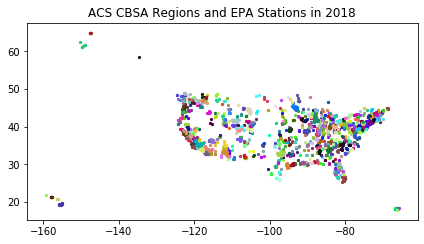

In [17]:
# random rgb value generator
r = lambda: random.randint(0,255)

# just good to knnow
no_stations = []

# set up plot
print('starting')
dpi=72
plt.figure(figsize=(1920/dpi,1080/dpi),dpi=dpi)
fig, ax = plt.subplots()
for i in range(len(regions)):
    # check if this region has any stations
    geoid = regions.loc[i]['CBSAFP']
    sts = stations[stations.acs_geoid==int(geoid)]
    if sts.size > 0:
        # random color for this region
        c = '#%02x%02x%02x' % (r(), r(), r())

        # plot region
        # regions.loc[[i],'geometry'].plot(ax=ax, color='white', edgecolor=c)

        # plot stations
        gdf = gp.GeoDataFrame(sts, geometry=gp.points_from_xy(sts.longitude, sts.latitude))
        gdf.plot(ax=ax, marker='o', color=c, markersize=5)
    else:
        print('%d: no stations in region %s, ignoring' % (i, geoid))
        no_stations.append(geoid)

print('wrapping up')
plt.title('ACS CBSA Regions and EPA Stations in %s' % year)
plt.tight_layout()
plt.savefig('./figs/2/epa_stations_in_acs_regions_2018.png')

print('found %d regions without stations:' % len(no_stations))
print(no_stations)